In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, "../..")
from simulations import van_der_pol_oscillator
from itertools import product
from prototype_nn import Splitting, predictions, tensor_flatten
import matplotlib.pyplot as plt
import torch
%run ../utilities.ipynb

## Training set : Simulations

## Dataframes

This is the simulations we use for training. The initial parameters x,y are within set [1,2,3,45]

In [2]:
training = pd.DataFrame(data = pd.read_csv("../../data/train/van.csv"))
training.head()

,time,x,y,initial_x,initial_y
0,0.000,1.000000,1.000000,1,1
1,0.001,1.000999,0.998999,1,1
2,0.002,1.001998,0.997996,1,1
3,0.003,1.002995,0.996991,1,1
4,0.004,1.003992,0.995984,1,1


In [3]:
len(training)

321600

This is to zip the initial parameters columns together

In [4]:
training["initial_parameters"] = list(zip(training.initial_x, training.initial_y))
training.head()

,time,x,y,initial_x,initial_y,initial_parameters
0,0.000,1.000000,1.000000,1,1,"(1, 1)"
1,0.001,1.000999,0.998999,1,1,"(1, 1)"
2,0.002,1.001998,0.997996,1,1,"(1, 1)"
3,0.003,1.002995,0.996991,1,1,"(1, 1)"
4,0.004,1.003992,0.995984,1,1,"(1, 1)"


This allows you to get the simulations where the initial parameters are x = 1, y = 1

In [5]:
initial_x1y1 = training[training["initial_parameters"] == (1,1)]

This would plots the graphs of inital parameters x = 1 , y = 1

<AxesSubplot:xlabel='time', ylabel='y'>

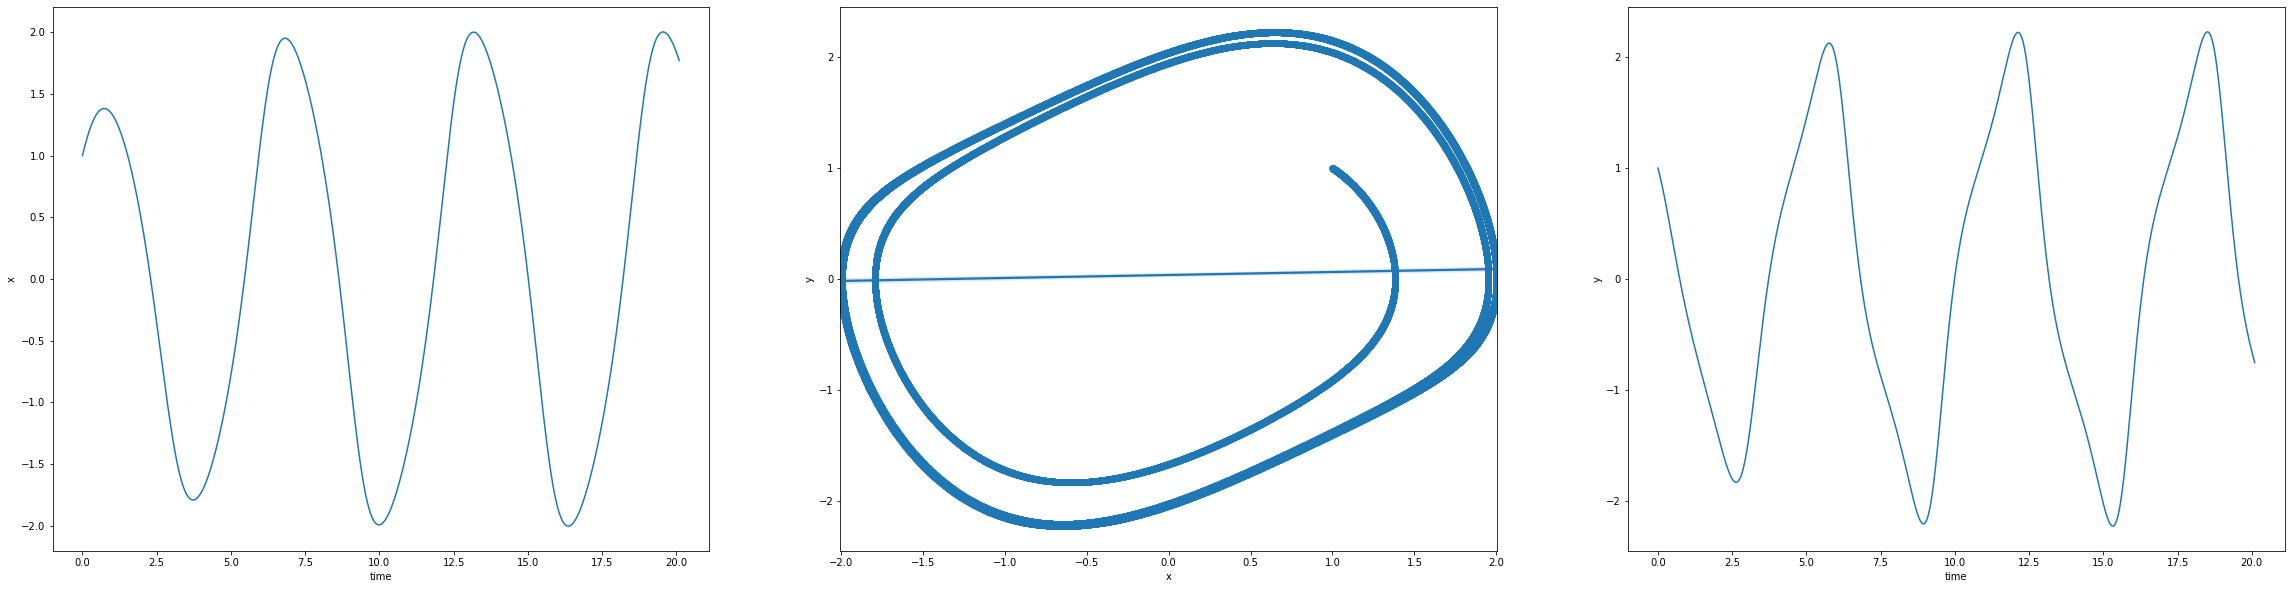

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(40,10))
sns.lineplot(data = initial_x1y1, x = "time", y = "x", ax=ax[0])
sns.regplot(data=initial_x1y1, x="x", y="y", ax=ax[1])
sns.lineplot(data = initial_x1y1, x = "time", y = "y", ax=ax[2])

## Cross validation

This is applying cross validation to our training data

In [7]:
# lr = 0.0001, bs = 15, ts = 15, epoch = 50
kfold = Splitting([0,3,4], [1,2], num_epoches = 20, batch_size = 32, lr= 0.00001)

In [ ]:
evaluate = kfold.cross_validation_evaluate(training, 5)

------------- Fold 0 -------------
TEST: 0 TRAIN: [1, 2, 3, 4]
Epoch: 0  Train Loss: 1.7287119626998901 
Epoch: 1  Train Loss: 1.023611068725586 
Epoch: 2  Train Loss: 1.0315630435943604 
Epoch: 3  Train Loss: 1.1432198286056519 
Epoch: 4  Train Loss: 0.7871190905570984 
Epoch: 5  Train Loss: 1.0954777002334595 
Epoch: 6  Train Loss: 0.9533036947250366 
Epoch: 7  Train Loss: 0.6985400319099426 
Epoch: 8  Train Loss: 0.824608564376831 
Epoch: 9  Train Loss: 0.40131160616874695 
Epoch: 10  Train Loss: 0.1710076481103897 
Epoch: 11  Train Loss: 0.1076284646987915 
Epoch: 12  Train Loss: 0.0783582329750061 
Epoch: 13  Train Loss: 0.0536312460899353 
Epoch: 14  Train Loss: 0.15371325612068176 
Epoch: 15  Train Loss: 0.04081987962126732 
Epoch: 16  Train Loss: 0.015651041641831398 
Epoch: 17  Train Loss: 0.023571325466036797 
Epoch: 18  Train Loss: 0.018307555466890335 
Epoch: 19  Train Loss: 0.012834121473133564 
------------- Fold 1 -------------
TEST: 1 TRAIN: [0, 2, 3, 4]
Epoch: 0  Train

This is the evaluatons from the cross validation

In [9]:
evaluate

[tensor(0.0212, grad_fn=<MseLossBackward>),
 tensor(0.0112, grad_fn=<MseLossBackward>),
 tensor(0.0524, grad_fn=<MseLossBackward>),
 tensor(0.0100, grad_fn=<MseLossBackward>),
 tensor(0.0097, grad_fn=<MseLossBackward>)]

Measures the average of the evaluations

In [10]:
average_loss = 0
for x in evaluate:
    average_loss += x.item()
average_loss/len(evaluate)

0.02089237663894892

## Training Data : Predictions

This loads the predictions of the training data.

In [11]:
training_preds = pd.DataFrame(data = pd.read_csv("../../data/preds/train/van.csv"))
training_preds.head()

,time,initial_x,initial_y,x,y
0,0.000,1,1,0.878540,1.075928
1,0.001,1,1,0.880194,1.073958
2,0.002,1,1,0.881844,1.071989
3,0.003,1,1,0.883496,1.070020
4,0.004,1,1,0.885149,1.068051


This manipulate the "training_preds" dataframes (we drop columns, and rename some columns) to be later used for plotting graphs

In [12]:
training_preds = training_preds.drop(columns = ["initial_x", "initial_y", "time"])
training_preds = training_preds.rename(columns={
                                            'x' : 'x_preds',
                                            'y' : 'y_preds'})

This shows the first 4 rows of the training predictions.

In [13]:
training_preds.head()

,x_preds,y_preds
0,0.878540,1.075928
1,0.880194,1.073958
2,0.881844,1.071989
3,0.883496,1.070020
4,0.885149,1.068051


This combines the training data and predictions dataframe together

In [14]:
training_and_predictions = pd.merge(training, training_preds, right_index=True, left_index=True)

This is the first 5 rows within the dataframes 

In [15]:
training_and_predictions.head()

,time,x,y,initial_x,initial_y,initial_parameters,x_preds,y_preds
0,0.000,1.000000,1.000000,1,1,"(1, 1)",0.878540,1.075928
1,0.001,1.000999,0.998999,1,1,"(1, 1)",0.880194,1.073958
2,0.002,1.001998,0.997996,1,1,"(1, 1)",0.881844,1.071989
3,0.003,1.002995,0.996991,1,1,"(1, 1)",0.883496,1.070020
4,0.004,1.003992,0.995984,1,1,"(1, 1)",0.885149,1.068051


This function is defined to be later used for plotting graphs

In [16]:
def hue(df, hue):
    for var in hue:
        columns = list(df.columns)
        columns.remove(var)
        columns.remove("{}_{}".format(var,"preds"))
        df = df.melt(columns, var_name=var, value_name = f"{var}value")
    return df

## Graphs

Looking at training simulations compared to the predictions. This produces a high results

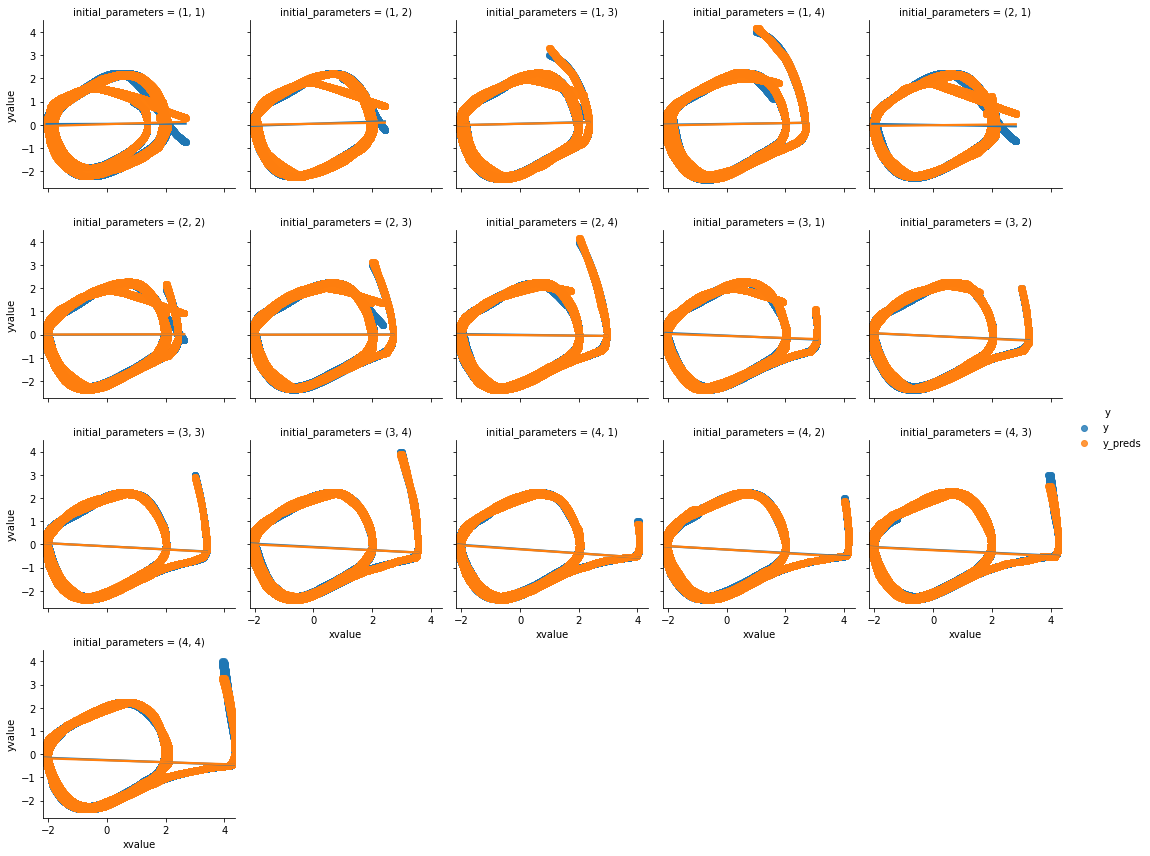

In [17]:
g = sns.FacetGrid(hue(training_and_predictions, ["x", "y"]), col="initial_parameters", hue="y", col_wrap=5,)
g.map(sns.regplot, "xvalue", "yvalue", ci=None)
g.add_legend()

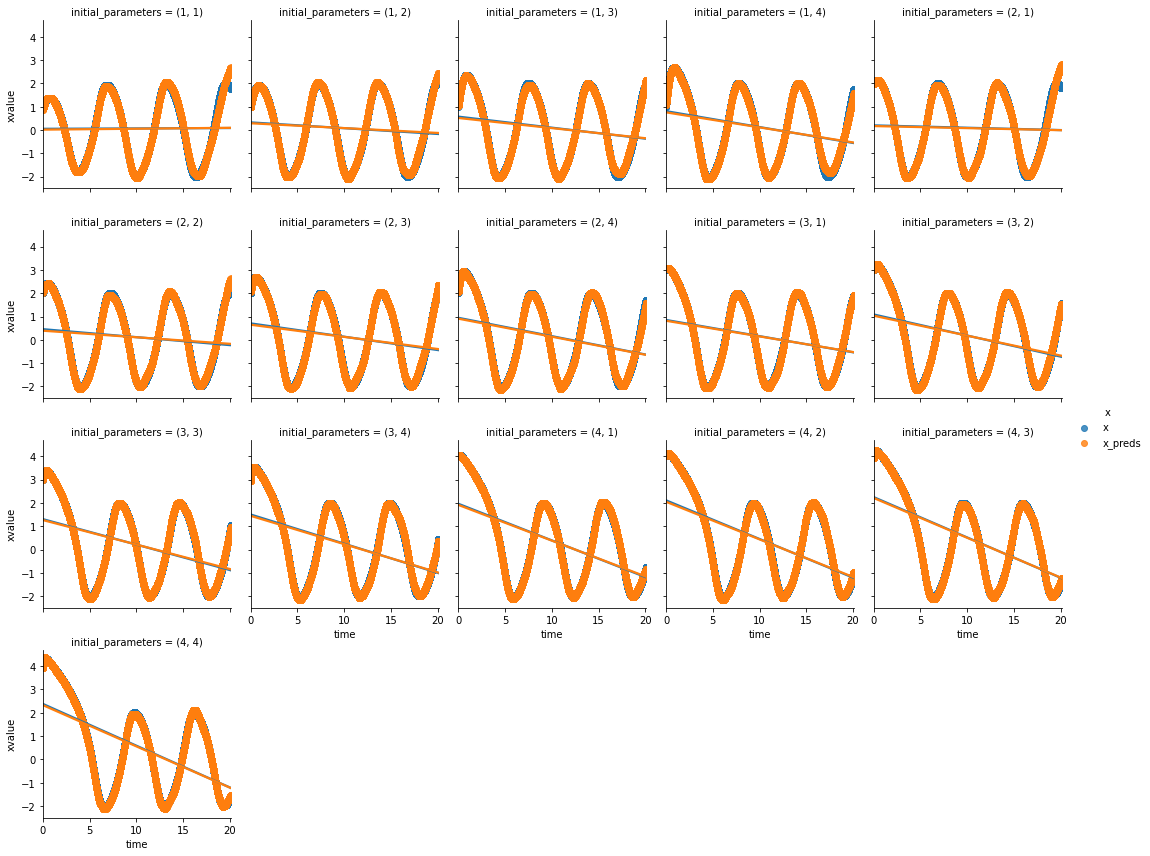

In [18]:
g = sns.FacetGrid(hue(training_and_predictions, ["x"]), col="initial_parameters", hue="x", col_wrap=5,)
g.map(sns.regplot, "time", "xvalue", ci=None)
g.add_legend()

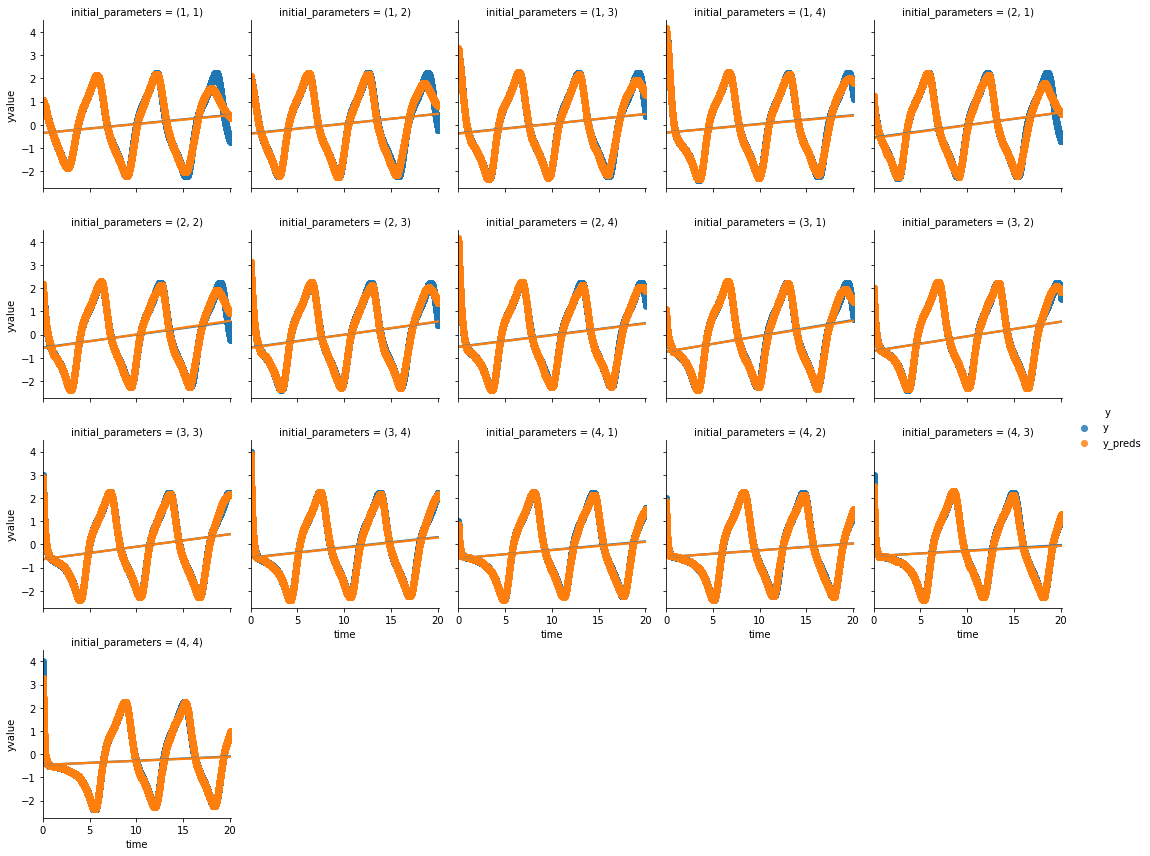

In [19]:
g = sns.FacetGrid(hue(training_and_predictions, ["y"]), col="initial_parameters", hue="y", col_wrap=5,)
g.map(sns.regplot, "time", "yvalue", ci=None)
g.add_legend()

## Testing : Simulations

This is produces simulations which will now be used as testing data. Where we have initial parameters in set [5,6]

In [20]:
testing = van_der_pol_oscillator(delta = 0.001, simulations = 20.1, save = False, initial_paras = np.round(np.random.uniform(0, 5, 4), 2))

This puts the inital parameters columns into one column as tuple

In [21]:
testing["initial_parameters"] = list(zip(testing.initial_x, testing.initial_y))
testing.head()

,time,x,y,initial_x,initial_y,initial_parameters
0,0.000,1.160000,1.160000,1.16,1.16,"(1.16, 1.16)"
1,0.001,1.161159,1.158638,1.16,1.16,"(1.16, 1.16)"
2,0.002,1.162317,1.157274,1.16,1.16,"(1.16, 1.16)"
3,0.003,1.163474,1.155907,1.16,1.16,"(1.16, 1.16)"
4,0.004,1.164629,1.154538,1.16,1.16,"(1.16, 1.16)"


In [22]:
len(testing)

321600

## Testing : Predictions

This will be used for getting the predictions of the testing data

In [23]:
def testing_preds(test_df):
    inputs = torch.tensor(test_df.iloc[ :, [0,3,4]].values)
    targets = torch.tensor(test_df.iloc[:, [1,2]].values)
    preds, _ = predictions(num_inputs=3, num_classes=2, learning_rate=0.0005, batch_size=1, num_epochs=1, inputs=inputs.float(), targets=targets.float(), train=False, path= "../../data/state/van.pth")
    data = {'time' : test_df.time.values,
            'initial_parameters' : test_df.initial_parameters.values,
            'x' : tensor_flatten(preds[:,0]), 'y' : tensor_flatten(preds[:, 1])}
    return pd.DataFrame(data = data, columns = ["time", "x", "y", "initial_parameters"]);

In [24]:
testing_preds = testing_preds(testing)

In [25]:
len(testing_preds)

321600

In [26]:
testing_preds.head()

,time,x,y,initial_parameters
0,0.000,1.038252,1.259133,"(1.16, 1.16)"
1,0.001,1.039971,1.257215,"(1.16, 1.16)"
2,0.002,1.041689,1.255300,"(1.16, 1.16)"
3,0.003,1.043408,1.253384,"(1.16, 1.16)"
4,0.004,1.045126,1.251468,"(1.16, 1.16)"


This is manipulating the dataframes, for it to be later used in plotting graphs

In [27]:
testing_preds = testing_preds.rename(columns={"x" : "x_preds", "y" : "y_preds"})

In [28]:
testing_and_predictions = pd.merge(testing, testing_preds, right_on=["time", "initial_parameters"], left_on=["time", "initial_parameters"])

In [29]:
testing_and_predictions.head()

,time,x,y,initial_x,initial_y,initial_parameters,x_preds,y_preds
0,0.000,1.160000,1.160000,1.16,1.16,"(1.16, 1.16)",1.038252,1.259133
1,0.001,1.161159,1.158638,1.16,1.16,"(1.16, 1.16)",1.039971,1.257215
2,0.002,1.162317,1.157274,1.16,1.16,"(1.16, 1.16)",1.041689,1.255300
3,0.003,1.163474,1.155907,1.16,1.16,"(1.16, 1.16)",1.043408,1.253384
4,0.004,1.164629,1.154538,1.16,1.16,"(1.16, 1.16)",1.045126,1.251468


## Graphs

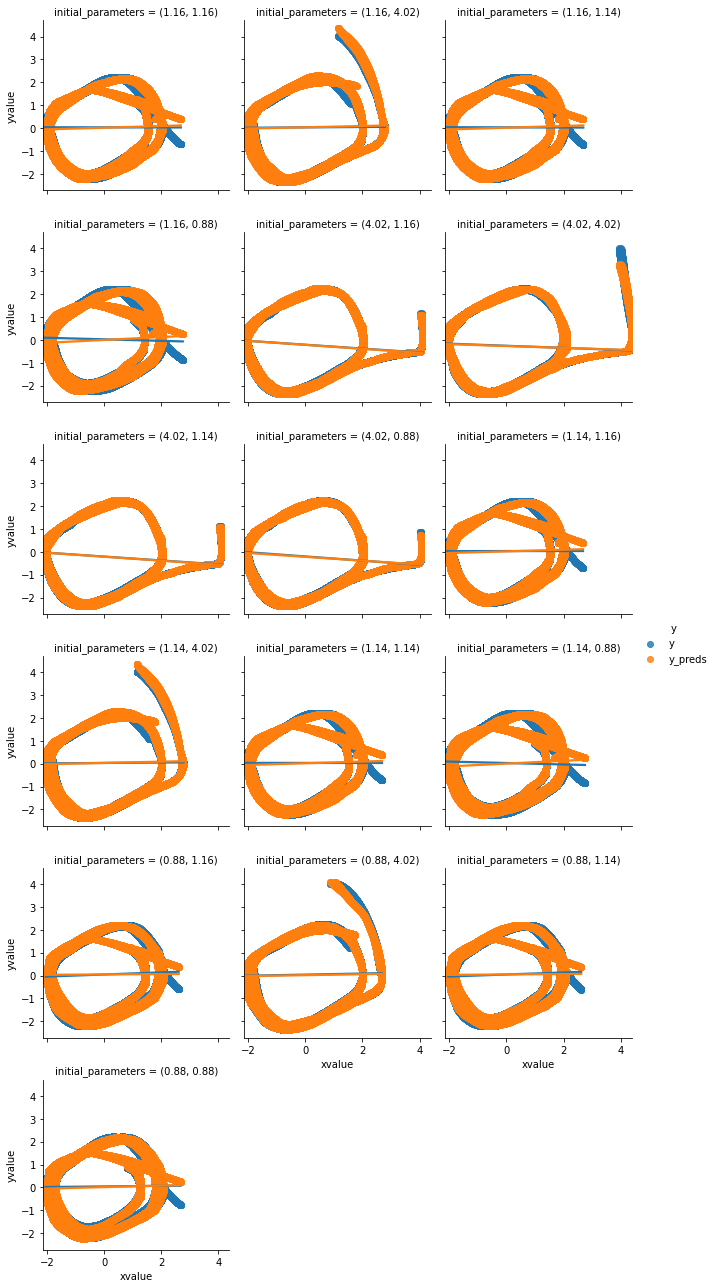

In [30]:
g = sns.FacetGrid(hue(testing_and_predictions, ["x", "y"]), col_wrap=3, col="initial_parameters", hue="y")
g.map(sns.regplot, "xvalue", "yvalue", ci=None)
g.add_legend()

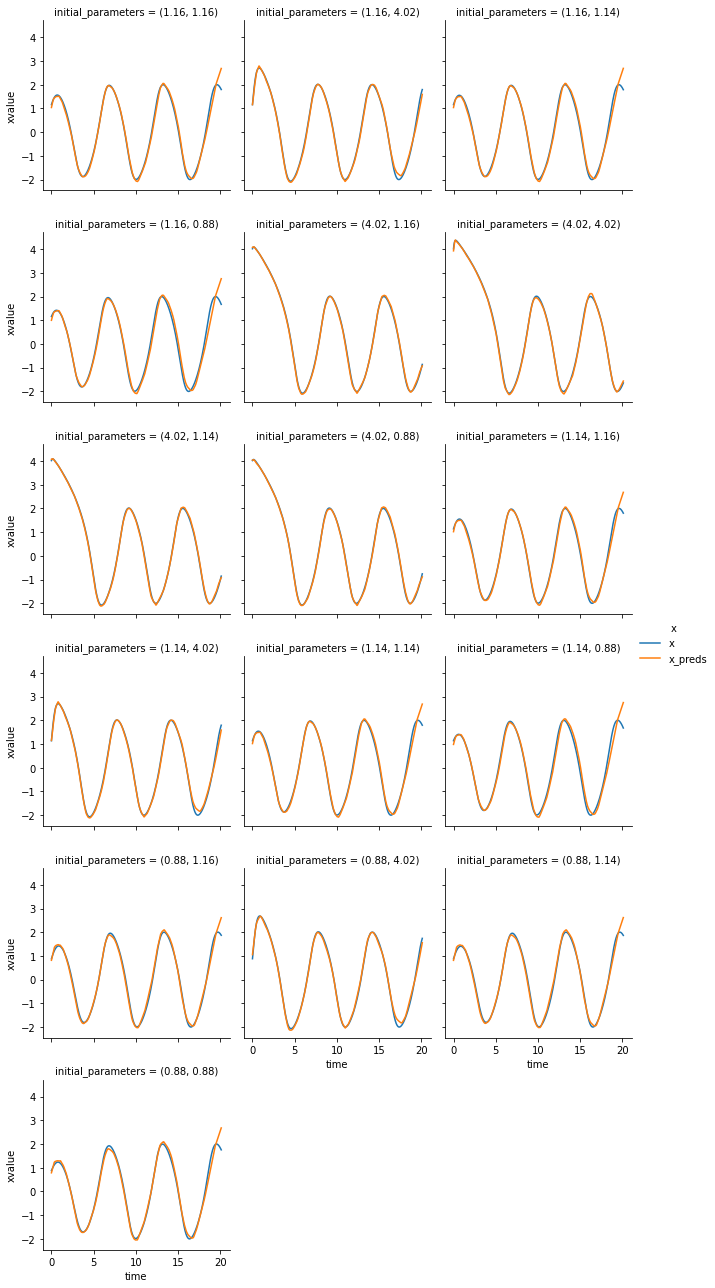

In [31]:
g = sns.FacetGrid(hue(testing_and_predictions, ["x"]), col_wrap=3, col="initial_parameters", hue="x",)
g.map(sns.lineplot, "time", "xvalue", ci=None)
g.add_legend()

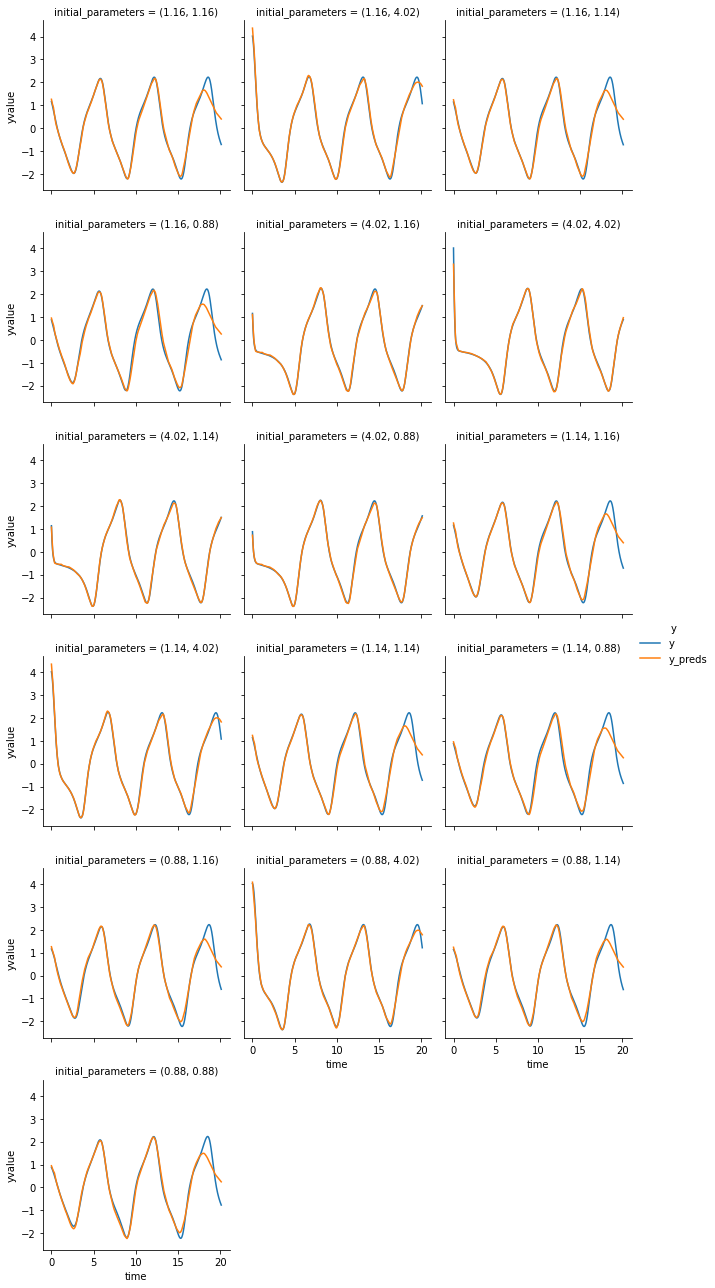

In [32]:
g = sns.FacetGrid(hue(testing_and_predictions, ["y"]), col_wrap=3, col="initial_parameters", hue="y")
g.map(sns.lineplot, "time", "yvalue", ci=None)
g.add_legend()

### Loss my simulations

This is section is demonstrating how the loss changes for a certain individual.

Below is the dataframes we are using:
    <ol>
    <li> testing - the simulations testing data </li>
    <li> testing_predictions - the predictions of the simulation testing data </li>
    </ol>

In [33]:
testing.head()

,time,x,y,initial_x,initial_y,initial_parameters
0,0.000,1.160000,1.160000,1.16,1.16,"(1.16, 1.16)"
1,0.001,1.161159,1.158638,1.16,1.16,"(1.16, 1.16)"
2,0.002,1.162317,1.157274,1.16,1.16,"(1.16, 1.16)"
3,0.003,1.163474,1.155907,1.16,1.16,"(1.16, 1.16)"
4,0.004,1.164629,1.154538,1.16,1.16,"(1.16, 1.16)"


In [35]:
testing_preds.head()

,time,x_preds,y_preds,initial_parameters
0,0.000,1.038252,1.259133,"(1.16, 1.16)"
1,0.001,1.039971,1.257215,"(1.16, 1.16)"
2,0.002,1.041689,1.255300,"(1.16, 1.16)"
3,0.003,1.043408,1.253384,"(1.16, 1.16)"
4,0.004,1.045126,1.251468,"(1.16, 1.16)"


This is the lossBySimulation function. This provides us with the loss for each simulatin

In [38]:
simulationLoss, _ = lossBySimulations(testing, testing_preds, [1,2])

This is the simulationLoss dataframe, showing the inital parameters (simulation) and the corresponding loss

In [39]:
simulationLoss.head()

,initial_parameters,Loss
0,0.88 0.88,0.041876
1,0.88 1.14,0.033945
2,0.88 1.16,0.033835
3,0.88 4.02,0.006901
4,1.14 0.88,0.057044


This is a bar box plot of that simulation

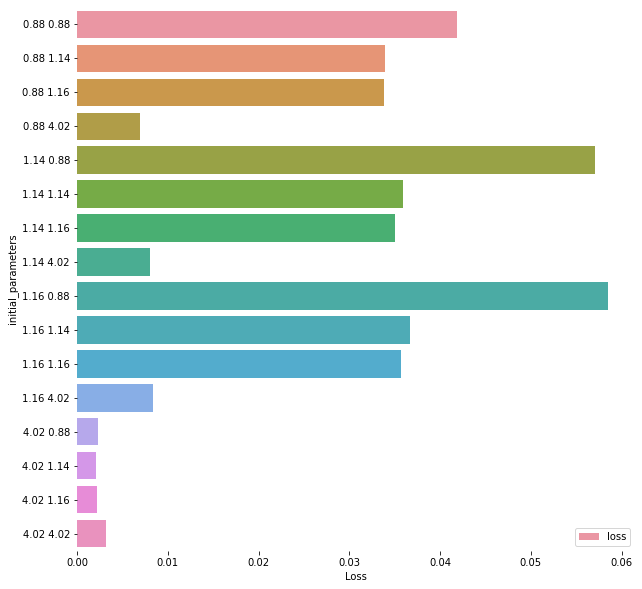

In [43]:
simulaPlots("Loss", "initial_parameters", simulationLoss, figsize = (10,10))

The lossByTime function would provide a loss for a specfic time for a certain simulation

In [45]:
timeLoss, _ = lossByTime(testing, testing_preds, [1,2])

The timeLoss now holds the loss corresponding to a specific time for a intial_parameter (simulation). This is demonstrated below

In [46]:
timeLoss.head()

,Time,initial_parameters,Loss
0,0.000,"(0.88, 0.88)",0.006602
1,0.001,"(0.88, 0.88)",0.006533
2,0.002,"(0.88, 0.88)",0.006465
3,0.003,"(0.88, 0.88)",0.006398
4,0.004,"(0.88, 0.88)",0.006330


The graphs showning these plots

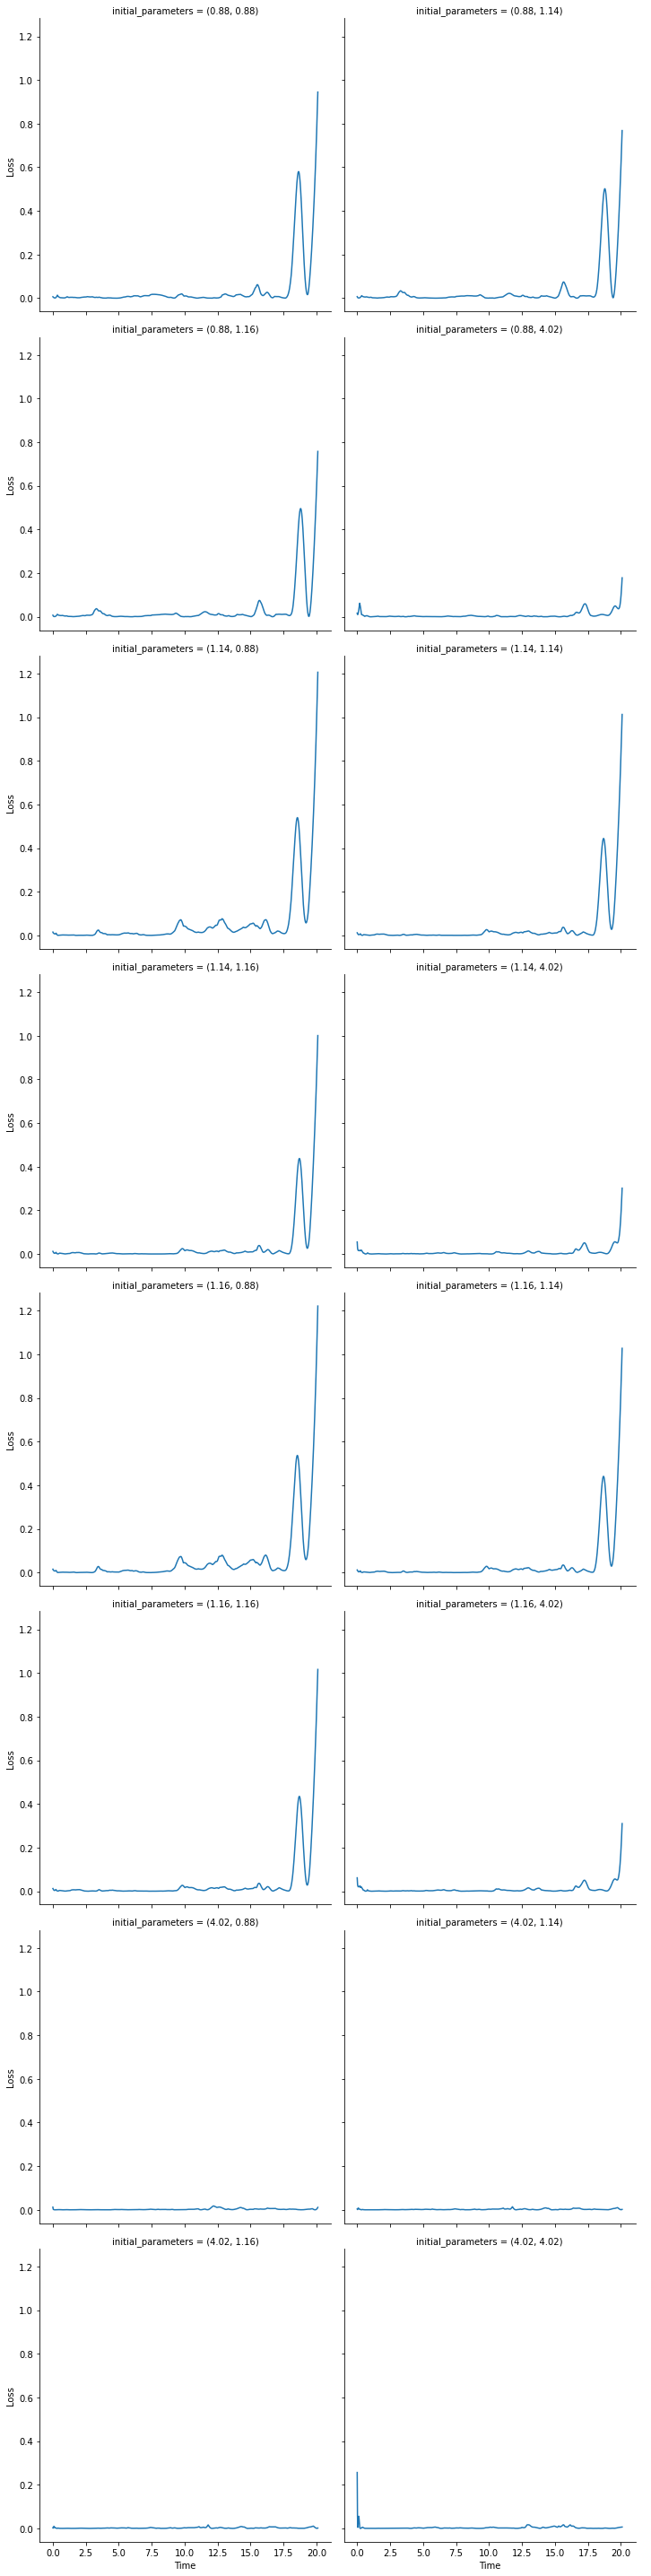

In [47]:
g = sns.FacetGrid(data = timeLoss, col = "initial_parameters", height = 5, col_wrap=2)
g.map(sns.lineplot, "Time", "Loss", ci=None)
g.add_legend()